In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        #LSTM
        self.lstm = nn.LSTM(input_size, hidden_size).to(device)
        self.hidden2Cat = nn.Linear(hidden_size, output_size).to(device)
        self.hidden = self.init_hidden()

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input, self.hidden)
        output = self.hidden2Cat(lstm_out[-1]) #many to one
        output = F.log_softmax(output, dim=1)

        return output

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size).to(device),
                torch.zeros(1, 1, self.hidden_size).to(device))

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import random

def findFiles(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Build the category_lines dictionary, a list of names per language
category_lines = {}
category_lines_test = {}
all_categories = []
split_size = 0.92


# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    split = int(len(lines) * split_size)
    category_lines[category] = lines[0:split]
    category_lines_test[category] = lines[split:-1]

n_categories = len(all_categories)

In [3]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(train_set=True):
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category] if train_set else category_lines_test[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

# Just return an output given a line
def evaluate(line_tensor):
    rnn.hidden = rnn.init_hidden()
    output = rnn(line_tensor)

    return output

In [4]:
#negative log likelihood loss
criterion = nn.NLLLoss()
learning_rate = 0.0012
n_iters = 25_000

n_hidden = 256
rnn = RNN(n_letters, n_hidden, n_categories) #LSTM model
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

5000 20% (0m 26s) 0.2372 Starek / Polish ✓
10000 40% (0m 53s) 0.3009 Kamo / Japanese ✓
15000 60% (1m 24s) 1.0696 Boyd / English ✓
20000 80% (1m 55s) 0.5898 Aiello / Italian ✓
25000 100% (2m 22s) 0.0198 Rhee / Korean ✓


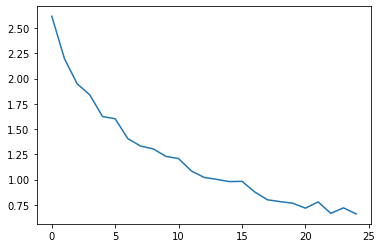

In [5]:
import time
import math
import matplotlib.pyplot as plt

def train(category_tensor, line_tensor):

    rnn.zero_grad()
    rnn.hidden = rnn.init_hidden()

    output = rnn(line_tensor)[-1]

    loss = criterion(output.unsqueeze(0), category_tensor)
    loss.backward()

    optimizer.step()

    return output.unsqueeze(0), loss.item()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

print_every = 5_000
plot_every = 1_000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor.to(device), line_tensor.to(device))
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
# Show the loss
plt.figure()
plt.plot(all_losses)
plt.show()

In [6]:
def confusion_plot(y_category, train_set=True):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 50_000
    correct = 0
    
    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):

        category, line, category_tensor, line_tensor = randomTrainingExample(train_set)
        output = evaluate(line_tensor.to(device))
        output = output.unsqueeze(0)

        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1
        if category_i == guess_i: correct += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + y_category, rotation=90)
    ax.set_yticklabels([''] + y_category)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()
    print(f"accuracy = {correct / n_confusion}")

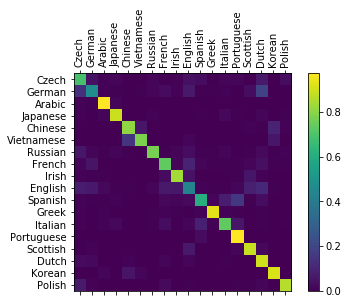

accuracy = 0.79224


In [7]:
confusion_plot(all_categories)

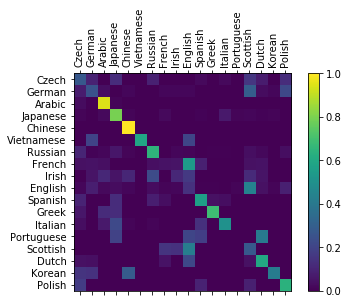

accuracy = 0.47802


In [8]:
confusion_plot(all_categories, False)

In [9]:
def predict(word, n_predictions=4):
        print(f'\n>{word}')
        with torch.no_grad():
            output = evaluate(lineToTensor(word))

            # get top N categories
            topv, topi = output.topk(n_predictions, 1, True)
            for i in range(n_predictions):
                value = topv[0][i].item()
                category_index = topi[0][i].item()
                print('(%.2f) %s' % (value, all_categories[category_index]))


In [10]:
predict("Zhao")
predict("Alah")
predict("Shiomi")
predict("Connor")
predict("Hernandez")
predict("Voltaire")
predict("Paganni")
predict("Schneider")
predict("Yun")
predict("Sayaka")
predict("Tomoyo")
predict("Alah")
predict("Perez")



>Zhao
(-0.02) Chinese
(-4.73) Scottish
(-5.46) Korean
(-6.42) Japanese

>Alah
(-1.37) Arabic
(-1.40) Irish
(-1.65) Czech
(-2.58) English

>Shiomi
(-0.02) Japanese
(-4.65) Arabic
(-5.50) Czech
(-5.59) Italian

>Connor
(-0.90) Arabic
(-1.08) Irish
(-2.35) English
(-3.16) French

>Hernandez
(-0.09) Spanish
(-2.52) Portuguese
(-5.34) Polish
(-6.38) German

>Voltaire
(-0.05) French
(-3.48) English
(-4.92) German
(-5.97) Irish

>Paganni
(-0.03) Italian
(-4.15) Russian
(-4.87) Japanese
(-6.04) Spanish

>Schneider
(-0.01) Dutch
(-4.93) Czech
(-5.65) German
(-7.35) English

>Yun
(-0.02) Chinese
(-4.04) Korean
(-6.71) Vietnamese
(-7.25) Scottish

>Sayaka
(-0.01) Japanese
(-5.18) Russian
(-5.55) Czech
(-7.37) Italian

>Tomoyo
(-0.03) Japanese
(-4.42) Russian
(-5.09) Spanish
(-5.56) Czech

>Alah
(-1.37) Arabic
(-1.40) Irish
(-1.65) Czech
(-2.58) English

>Perez
(-0.03) Spanish
(-4.44) Portuguese
(-5.22) German
(-5.34) Dutch
